In [186]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import ngrams
from collections import Counter
from wordcloud import WordCloud
import seaborn as sns

### Reading The Data

In [187]:
df = pd.read_csv('train_150k.txt', sep='\t', header = None)

In [188]:
df = df.reindex(columns=[1, 0]).rename(columns={1: "tweet_text", 0: "pos_neg"})

### Exploring The Data

In [189]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149985 entries, 0 to 149984
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   tweet_text  149985 non-null  object
 1   pos_neg     149985 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.3+ MB


In [190]:
df.shape

(149985, 2)

In [191]:
df.head(10)

,tweet_text,pos_neg
0,Starting back at work today Looks like it'l...,0
1,Sugar levels dropping... munchies setting in. ...,1
2,@karineb22 yeah!!! have a great summer break!,1
3,hannah montana was very good. now going to re...,1
4,"@Mayra326 aww, have fun! I just had my 3D las...",1
5,Worried about my cat. Took him to the vet and ...,0
6,Dancing on cloud nine with my significant othe...,1
7,@asherroth omg pls take one for me all i have ...,0
8,How did i get stuck watchin over everything Sm...,0
9,@sunday67 : only 5 days remaining,0


In [192]:
df.tail()

,tweet_text,pos_neg
149980,Had a great night at Tabs but now I'm missing ...,0
149981,What a night at work.. Church in the morning,1
149982,this book is terrible im used 2 reading all ...,0
149983,@backstreetboys Updates? Any? I miss your upd...,0
149984,@lexiewohlfort I agree!,1


In [193]:
df.describe()

,pos_neg
count,149985.000000
mean,0.499823
std,0.500002
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [194]:
df.describe(include='object')

,tweet_text
count,149985
unique,149985
top,Starting back at work today Looks like it'l...
freq,1


In [195]:
df.isna().sum()

,0
tweet_text,0
pos_neg,0


В датасете нет пропусков.


In [196]:
duplicates = df.duplicated().sum()
duplicates

0

В датасете нет дубликатов.

In [197]:
df['pos_neg'].value_counts()

,count
pos_neg,
0,75019
1,74966


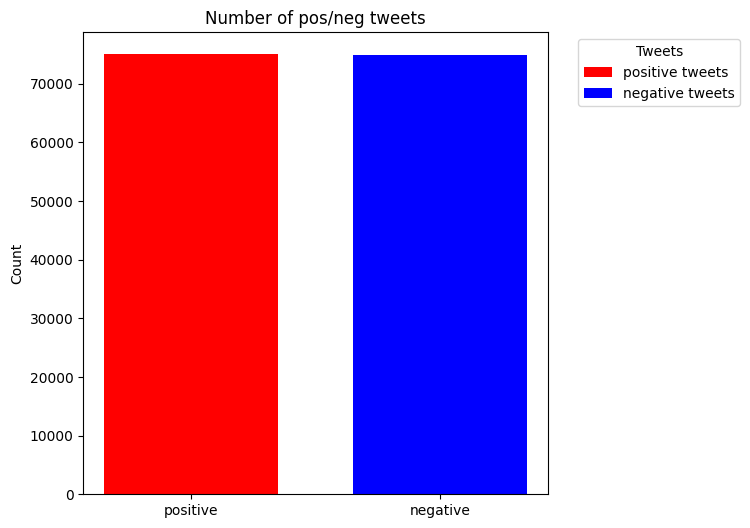

In [198]:
fig, ax = plt.subplots(figsize=(6, 6))
x_axis = ['positive', 'negative']
y_axis = [df['pos_neg'].value_counts()[0], df['pos_neg'].value_counts()[1]]
bar_labels = ['positive tweets', 'negative tweets']
bar_colors = ['red', 'blue']
ax.bar(x_axis, y_axis, label=bar_labels, color=bar_colors, width=0.7)
ax.set_ylabel('Count')
ax.set_title('Number of pos/neg tweets')
ax.legend(title='Tweets', bbox_to_anchor=(1.05, 1))
plt.show()

Количество слов в сообщении с удалением всех лишних пробелов, но со знаками препинания апострофами и другими символами.

In [199]:
" ".join(df['tweet_text'][2].split()).split(' ')

['@karineb22', 'yeah!!!', 'have', 'a', 'great', 'summer', 'break!']

In [200]:
df['tweet_text'].apply(lambda x: len(" ".join(x.strip().split()).split(' '))).value_counts()

,count
tweet_text,
8,8438
7,8344
6,8290
9,8206
10,7939
5,7660
11,7492
12,7250
13,6859


<Axes: >

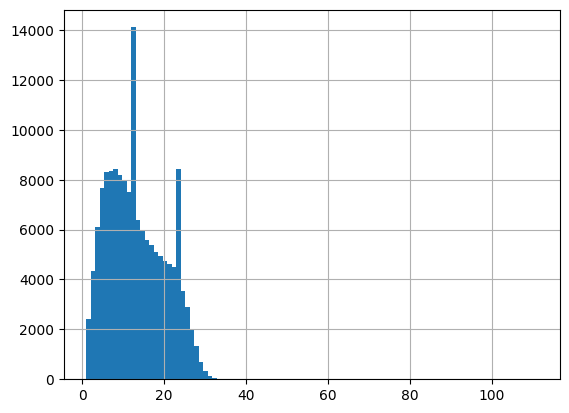

In [201]:
df['tweet_text'].apply(lambda x: len(" ".join(x.split()).split(' '))).hist(bins=100)

In [202]:
len(''.join(df['tweet_text'][2].strip().split())), ''.join(df['tweet_text'][2].strip().split())

(39, '@karineb22yeah!!!haveagreatsummerbreak!')

In [203]:
df['tweet_text'].apply(lambda x: len(''.join(x.strip().split()))).value_counts().head()

,count
tweet_text,
38,1975
35,1940
34,1935
32,1933
41,1927


<Axes: >

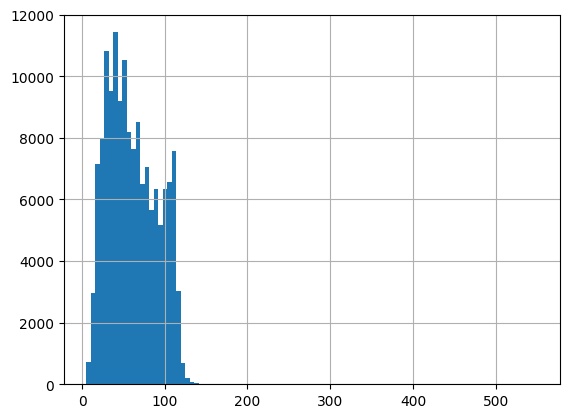

In [204]:
df['tweet_text'].apply(lambda x: len(''.join(x.strip().split()))).hist(bins=100)

### Preprocessing The Data

In [205]:
def clean_tweet(tweet):
    # Remove URLs
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE)
    # Remove user @ references and '#' from tweet
    tweet = re.sub(r'\@\w+|\#','', tweet)
    # Remove special characters, numbers, and punctuations
    tweet = re.sub(r'\W', ' ', tweet)
    tweet = re.sub(r'\d', ' ', tweet)
    tweet = re.sub(r'\s+', ' ', tweet)
    tweet = tweet.strip()
    return tweet

In [206]:
# Clean the training data
df['tweet_text'] = df['tweet_text'].apply(clean_tweet)

In [207]:
df.head()

,tweet_text,pos_neg
0,Starting back at work today Looks like it ll b...,0
1,Sugar levels dropping munchies setting in Luck...,1
2,yeah have a great summer break,1
3,hannah montana was very good now going to read...,1
4,aww have fun I just had my D last week,1


In [208]:
df['tweet_text'] = df['tweet_text'].str.lower()

In [209]:
df = df.dropna(subset=['tweet_text'])

In [210]:
df = df[df['tweet_text'].str.strip() != '']

In [211]:
df.head()

,tweet_text,pos_neg
0,starting back at work today looks like it ll b...,0
1,sugar levels dropping munchies setting in luck...,1
2,yeah have a great summer break,1
3,hannah montana was very good now going to read...,1
4,aww have fun i just had my d last week,1


In [212]:
df.shape

(149722, 2)

In [213]:
df.duplicated().sum()

2427

Появились дубликаты.

In [214]:
df = df.drop_duplicates(subset=['tweet_text'])

In [215]:
df.shape

(147166, 2)

Распределение количества слов в сообщениях после препроцессинга.

<Axes: >

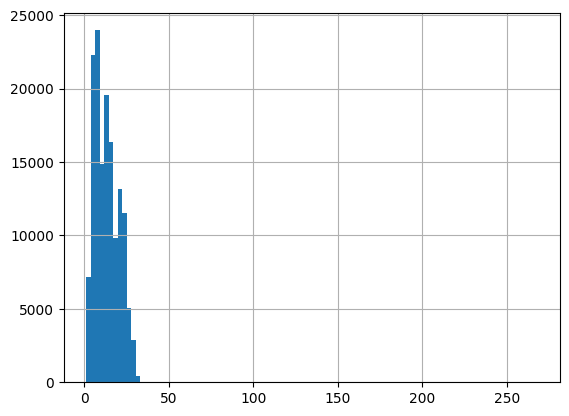

In [216]:
df['tweet_text'].apply(lambda x: len(" ".join(x.split()).split(' '))).hist(bins=100)

Распределение количества символов в сообщениях после препроцессинга.

<Axes: >

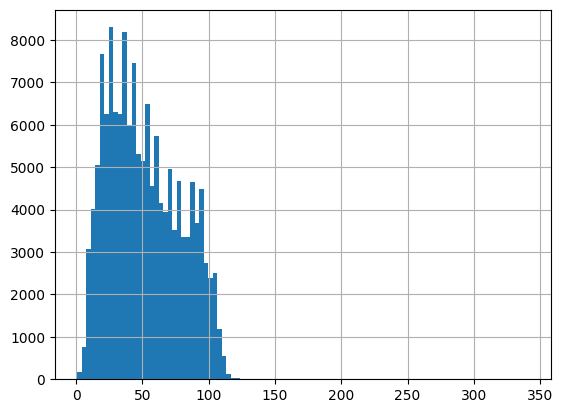

In [217]:
df['tweet_text'].apply(lambda x: len(''.join(x.strip().split()))).hist(bins=100)

In [218]:
df.head()

,tweet_text,pos_neg
0,starting back at work today looks like it ll b...,0
1,sugar levels dropping munchies setting in luck...,1
2,yeah have a great summer break,1
3,hannah montana was very good now going to read...,1
4,aww have fun i just had my d last week,1


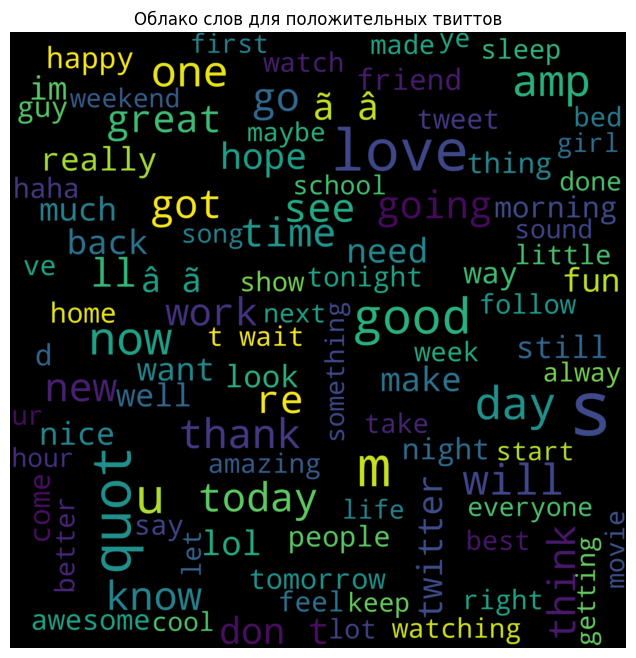

In [219]:
word_cloud_text = ''.join(df[df["pos_neg"]==1].tweet_text)
wordcloud = WordCloud(
    max_font_size=100,
    max_words=100,
    background_color="black",
    scale=10,
    width=800,
    height=800
).generate(word_cloud_text)
#Figure properties
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Облако слов для положительных твиттов")
plt.show()

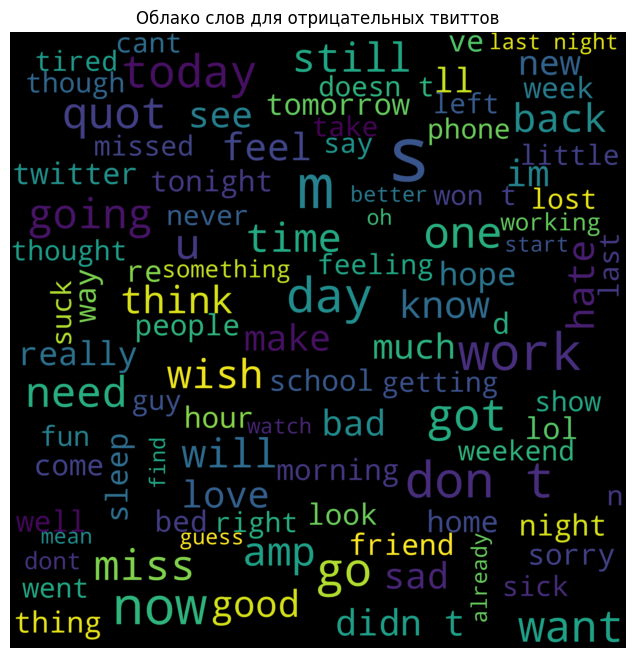

In [220]:
word_cloud_text = ''.join(df[df["pos_neg"]==0].tweet_text)
wordcloud = WordCloud(
    max_font_size=100,
    max_words=100,
    background_color="black",
    scale=10,
    width=800,
    height=800
).generate(word_cloud_text)
#Figure properties
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Облако слов для отрицательных твиттов")
plt.show()

##Split the Data

In [221]:
def lemmatize_and_tokenize(text):
    lemmatizer = WordNetLemmatizer()
    lemmatized = ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(text)])

    tokens = word_tokenize(lemmatized)

    return tokens

In [222]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [223]:
df['tweet_text'] = df['tweet_text'].apply(lemmatize_and_tokenize)

In [224]:
df.head()

,tweet_text,pos_neg
0,"[starting, back, at, work, today, look, like, ...",0
1,"[sugar, level, dropping, munchies, setting, in...",1
2,"[yeah, have, a, great, summer, break]",1
3,"[hannah, montana, wa, very, good, now, going, ...",1
4,"[aww, have, fun, i, just, had, my, d, last, week]",1


In [225]:
# ' '.join(df[df['pos_neg'] == 1]['tweet_text'].apply(lambda x: ' '.join(x))).split()

Top 20 words in positive tweets: [('i', 36380), ('the', 24823), ('to', 23520), ('a', 21004), ('you', 17864), ('it', 15787), ('and', 14106), ('my', 11961), ('for', 10971), ('is', 10199), ('in', 9502), ('s', 9110), ('of', 8483), ('on', 7951), ('that', 7863), ('me', 6744), ('so', 6250), ('with', 6212), ('have', 5829), ('m', 5769)]
Top 20 words in negative tweets: [('i', 53945), ('to', 29424), ('the', 24396), ('a', 19413), ('my', 18177), ('it', 17300), ('and', 14666), ('is', 12065), ('t', 11855), ('in', 10910), ('for', 9474), ('you', 9463), ('of', 8920), ('s', 8815), ('me', 8610), ('so', 8354), ('but', 8155), ('on', 8063), ('that', 7926), ('have', 7837)]


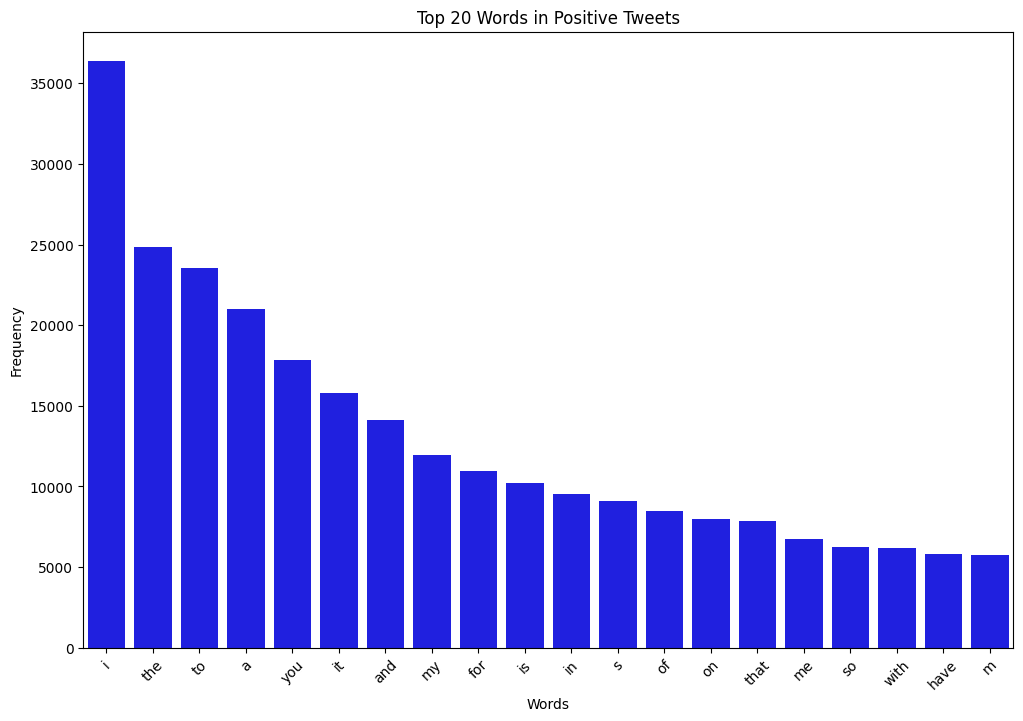

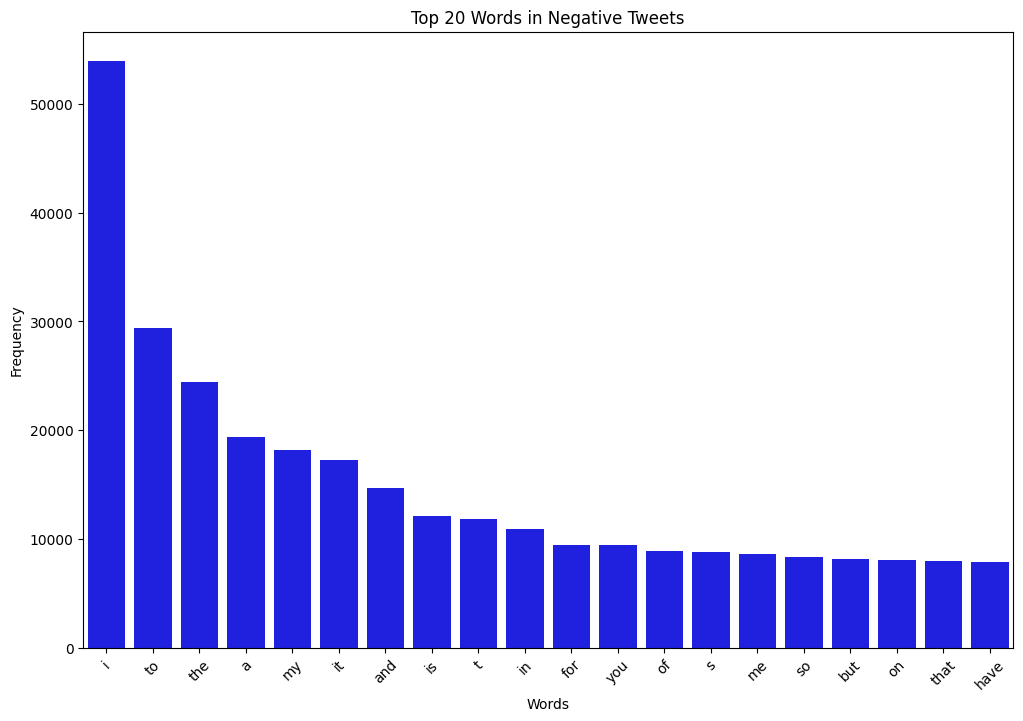

<ipython-input-226-fb9f93c5d44e>:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='pos_neg', y='length', data=df, palette='viridis')


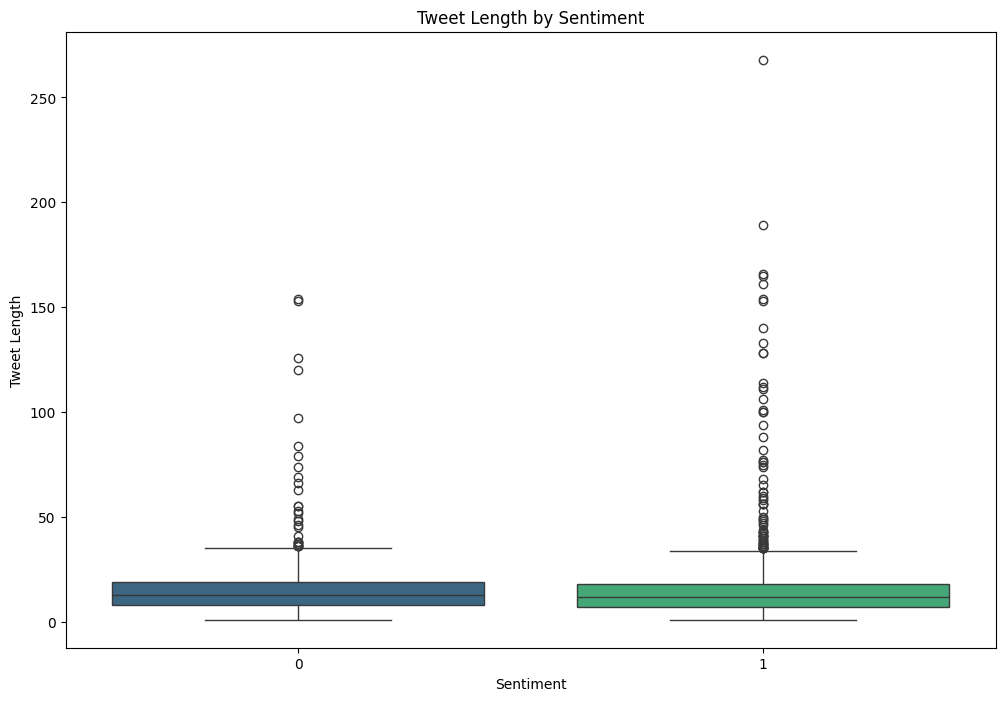

In [226]:
def get_top_words(column, n_top_words):
    words = ' '.join(column.apply(lambda x: ' '.join(x))).split()
    common_words = Counter(words).most_common(n_top_words)
    return common_words


positive_words = get_top_words(df[df['pos_neg'] == 1]['tweet_text'], 20)
print("Top 20 words in positive tweets:", positive_words)

negative_words = get_top_words(df[df['pos_neg'] == 0]['tweet_text'], 20)
print("Top 20 words in negative tweets:", negative_words)



plt.figure(figsize=(12, 8))
sns.barplot(x=[word for word, count in positive_words], y=[count for word, count in positive_words], color='blue')
plt.title('Top 20 Words in Positive Tweets')
plt.xticks(rotation=45)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()


plt.figure(figsize=(12, 8))
sns.barplot(x=[word for word, count in negative_words], y=[count for word, count in negative_words], color='blue')
plt.title('Top 20 Words in Negative Tweets')
plt.xticks(rotation=45)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()


df['length'] = df['tweet_text'].apply(len)
plt.figure(figsize=(12, 8))
sns.boxplot(x='pos_neg', y='length', data=df, palette='viridis')
plt.title('Tweet Length by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Tweet Length')
plt.show()

In [227]:
def plot_wordcloud(sentiment, title):
    words = ' '.join(df[df['pos_neg'] == sentiment]['tweet_text'].apply(lambda x: ' '.join(x)))
    wordcloud = WordCloud(
        max_font_size=100,
        max_words=100,
        background_color="black",
        scale=10
    ).generate(words)

    plt.figure(figsize=(12, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

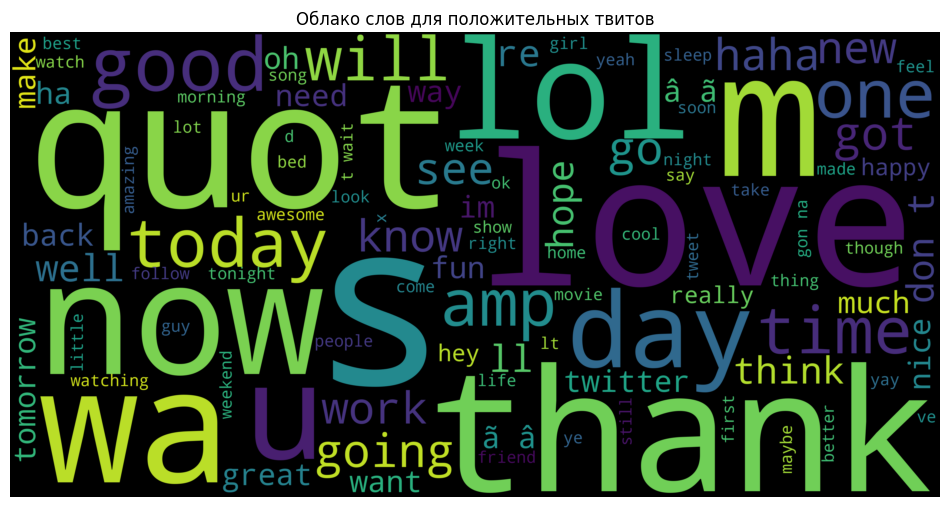

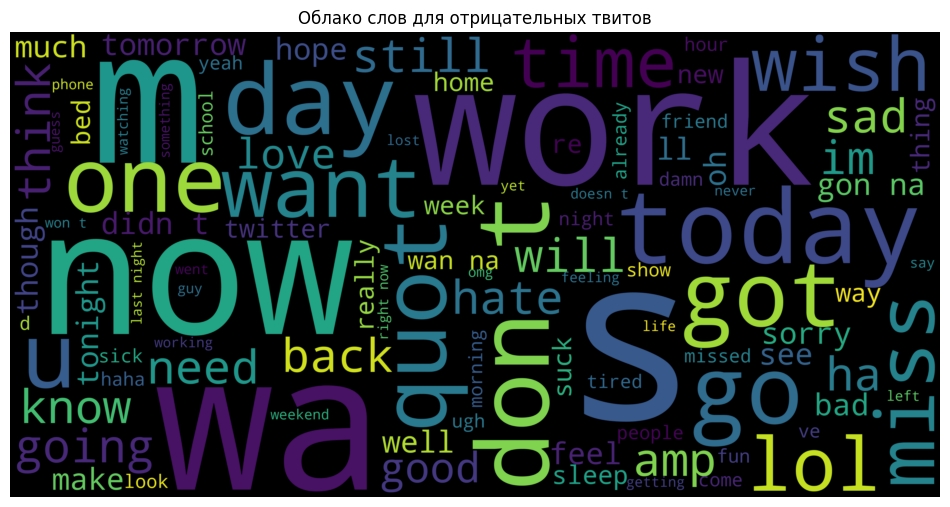

In [228]:
plot_wordcloud(1, "Облако слов для положительных твитов")
plot_wordcloud(0, "Облако слов для отрицательных твитов")

In [229]:
df.head()

,tweet_text,pos_neg,length
0,"[starting, back, at, work, today, look, like, ...",0,17
1,"[sugar, level, dropping, munchies, setting, in...",1,16
2,"[yeah, have, a, great, summer, break]",1,6
3,"[hannah, montana, wa, very, good, now, going, ...",1,10
4,"[aww, have, fun, i, just, had, my, d, last, week]",1,10


##Bigram&Trigram Analysis

In [235]:
# Function n_gram: splits the words in order to given parameter
# Parameter n: it's the "n" number for "n-gram"
def n_gram(n):
    n_grams = ngrams(' '.join(df['tweet_text'].apply(lambda x: ' '.join(x))).split(), n)
    return n_grams

In [236]:
sentences = []
df_frequency = []

In [237]:
# Function frequency: counts the frequency of the each "n-gram" output
# Parameter grammed: it takes the function "n_gram"s return as value. Briefly, the grammed text.
def frequency(grammed):
    sentences.clear()
    df_frequency.clear()
    freq = nltk.FreqDist(grammed)
    for k, v in freq.items():
        sentences.append(k)                     # Sentences is a list, stores the grams(ignores duplicates)
        df_frequency.append(v)                  # df_frequency is a list, stores the frequency of grams

In [238]:
# Function create_plot: it creates a plot for given grams
# Parameter num: it's a number to send it to "n_gram" function
def create_plot(num, count_head):
    frequency(n_gram(num)) # Send "num" parameter to "n_gram func." and send the result to "frequency func."

    gram_frame = pd.DataFrame(sentences)       # gram_frame is the data frame to store grams and freq.

    gram_frame['frequencies'] = df_frequency
    if num == 2:
        gram_frame.columns = ['first', 'second', 'frequencies']
    if num == 3:
        gram_frame.columns = ['first', 'second', 'third', 'frequencies']

    gram_frame.sort_values("frequencies", axis=0, ascending=False, inplace=True, na_position='last')

    gram_frame = gram_frame.head(count_head)            # Only take the top count_head of gram_frame

    total = sum(df_frequency)

    gram_frame["ratio"] = gram_frame['frequencies'].div(total)   # Additional, ratio is added

    plt.rcdefaults()
    fig, ax = plt.subplots()

    if num == 2:
        grams = gram_frame["first"] + " " + gram_frame["second"]
    if num == 3:
        grams = gram_frame["first"] + " " + gram_frame["second"] + " " + gram_frame["third"]

    # Create plot
    y_pos = np.arange(len(grams))
    performance = gram_frame["frequencies"]

    ax.barh(y_pos, performance)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(grams)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Frequency')
    if num == 2:
        ax.set_title('2 - grams')
    elif num == 3:
        ax.set_title('3 - grams')

    plt.show()
    display(gram_frame)

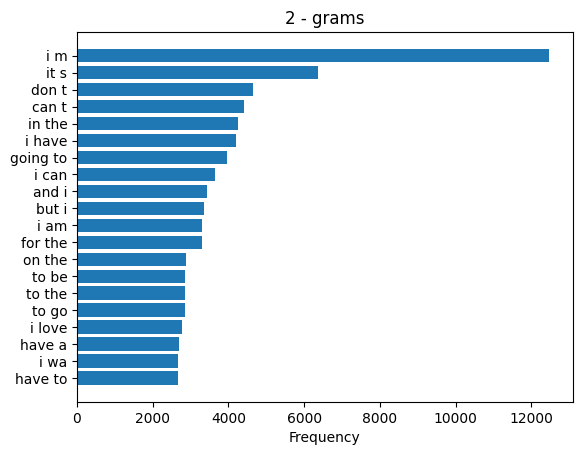

,first,second,frequencies,ratio
175,i,m,12478,0.006341
944,it,s,6358,0.003231
454,don,t,4655,0.002365
704,can,t,4406,0.002239
30,in,the,4255,0.002162
24,i,have,4205,0.002137
44,going,to,3970,0.002017
1181,i,can,3634,0.001847
564,and,i,3441,0.001749
805,but,i,3346,0.001700


In [239]:
create_plot(2, 20)

<ipython-input-238-8a3ed42f9743>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gram_frame["ratio"] = gram_frame['frequencies'].div(total)   # Additional, ratio is added


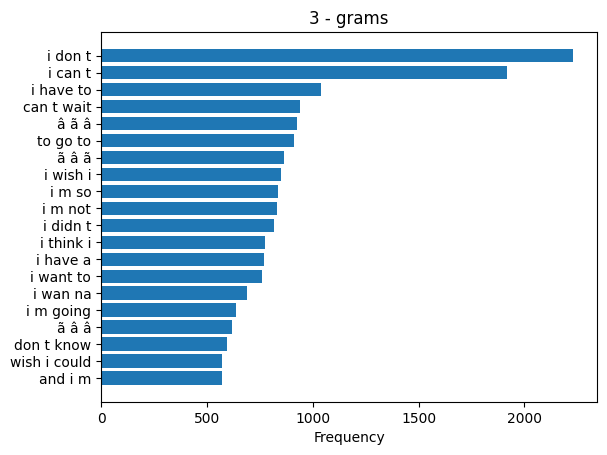

,first,second,third,frequencies,ratio
854,i,don,t,2232,0.001134
1591,i,can,t,1920,0.000976
1168,i,have,to,1040,0.000528
1686,can,t,wait,938,0.000477
4441,â,ã,â,927,0.000471
376,to,go,to,912,0.000463
4440,ã,â,ã,864,0.000439
5436,i,wish,i,848,0.000431
177,i,m,so,835,0.000424
557,i,m,not,830,0.000422


In [240]:
create_plot(3, 20)